# Imports

In [1759]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor , VotingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE
import xgboost
from sklearn.linear_model import LinearRegression

from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Settings

In [1760]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


# Read data

In [1761]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Adding building ID

In [1762]:
train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Combine data

In [1763]:
# Combine Data
X_o = pd.concat([X_train_observed_a, X_train_observed_b, X_train_observed_c])
X_e = pd.concat([X_train_estimated_a, X_train_estimated_b, X_train_estimated_c])
X_submission = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
y = pd.concat([train_a, train_b, train_c]).rename(columns={'time':'date_forecast'})

# Add isEstimated column
X_o['isEstimated'] = 0
X_e['isEstimated'] = 1
X_submission['isEstimated'] = 1

# Combine
X = pd.concat([X_o, X_e])



In [1764]:
# drop rows where we do not have the whole hour
fc_floored = X[['date_forecast','building_id']]
fc_floored['date_forecast'] = fc_floored['date_forecast'].dt.floor('H')

fc_floored = fc_floored['date_forecast'].astype(str) + fc_floored['building_id']

fc_00 = X.loc[X['date_forecast'].dt.minute==00,['date_forecast','building_id']]
fc_15 = X.loc[X['date_forecast'].dt.minute==15,['date_forecast','building_id']]
fc_30 = X.loc[X['date_forecast'].dt.minute==30,['date_forecast','building_id']]
fc_45 = X.loc[X['date_forecast'].dt.minute==45,['date_forecast','building_id']]

fc_00['date_forecast'] = fc_00.date_forecast.dt.floor('H')
fc_15['date_forecast'] = fc_15.date_forecast.dt.floor('H')
fc_30['date_forecast'] = fc_30.date_forecast.dt.floor('H')
fc_45['date_forecast'] = fc_45.date_forecast.dt.floor('H')

fc_00 = fc_00['date_forecast'].astype(str) + fc_00['building_id']
fc_15 = fc_15['date_forecast'].astype(str) + fc_15['building_id']
fc_30 = fc_30['date_forecast'].astype(str) + fc_30['building_id']
fc_45 = fc_45['date_forecast'].astype(str) + fc_45['building_id']

X = X[
    fc_floored.isin(fc_00) & fc_floored.isin(fc_15) & fc_floored.isin(fc_30)&  fc_floored.isin(fc_45)
]

/var/folders/s_/tyyjfphn3wl93jz8bhkrh3x40000gn/T/ipykernel_52366/3512278545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_floored['date_forecast'] = fc_floored['date_forecast'].dt.floor('H')


In [1765]:
X_00 = X[X['date_forecast'].dt.minute == 0].reset_index(drop=True)
X_15 = X[X['date_forecast'].dt.minute == 15].reset_index(drop=True)
X_30 = X[X['date_forecast'].dt.minute == 30].reset_index(drop=True)
X_45 = X[X['date_forecast'].dt.minute == 45].reset_index(drop=True)

X['date_forecast'] = X['date_forecast'].dt.floor('H')
X_mean = X.groupby(['date_forecast','building_id']).mean().sort_values(['building_id','date_forecast']).reset_index()

X_00.columns = ['00_' + col for col in X_00.columns]
X_15.columns = ['15_' + col for col in X_15.columns]
X_30.columns = ['30_' + col for col in X_30.columns]
X_45.columns = ['45_' + col for col in X_45.columns]
X_mean.columns = ['mean_' + col for col in X_mean.columns]

X = pd.concat([X_00, X_15, X_30, X_45, X_mean], axis=1)

keep_one_col_features = [
    'date_forecast',
    'elevation:m',
    'building_id',
    'date_calc',
    'isEstimated',
]

for feature in keep_one_col_features:
    X = X.rename(columns={f'00_{feature}':feature})

    drop_features = [f'15_{feature}',f'30_{feature}',f'45_{feature}',f'mean_{feature}']
    X = X.drop(columns=drop_features)



In [1766]:
mean_cols = [col for col in X.columns if 'mean_' in col]
mean_cols

['mean_absolute_humidity_2m:gm3',
 'mean_air_density_2m:kgm3',
 'mean_ceiling_height_agl:m',
 'mean_clear_sky_energy_1h:J',
 'mean_clear_sky_rad:W',
 'mean_cloud_base_agl:m',
 'mean_dew_or_rime:idx',
 'mean_dew_point_2m:K',
 'mean_diffuse_rad:W',
 'mean_diffuse_rad_1h:J',
 'mean_direct_rad:W',
 'mean_direct_rad_1h:J',
 'mean_effective_cloud_cover:p',
 'mean_fresh_snow_12h:cm',
 'mean_fresh_snow_1h:cm',
 'mean_fresh_snow_24h:cm',
 'mean_fresh_snow_3h:cm',
 'mean_fresh_snow_6h:cm',
 'mean_is_day:idx',
 'mean_is_in_shadow:idx',
 'mean_msl_pressure:hPa',
 'mean_precip_5min:mm',
 'mean_precip_type_5min:idx',
 'mean_pressure_100m:hPa',
 'mean_pressure_50m:hPa',
 'mean_prob_rime:p',
 'mean_rain_water:kgm2',
 'mean_relative_humidity_1000hPa:p',
 'mean_sfc_pressure:hPa',
 'mean_snow_density:kgm3',
 'mean_snow_depth:cm',
 'mean_snow_drift:idx',
 'mean_snow_melt_10min:mm',
 'mean_snow_water:kgm2',
 'mean_sun_azimuth:d',
 'mean_sun_elevation:d',
 'mean_super_cooled_liquid_water:kgm2',
 'mean_t_100

In [1767]:
# X.loc[:, ['00_date_forecast','mean_date_forecast']] 

In [1768]:
X_submission_00 = X_submission[X_submission['date_forecast'].dt.minute == 0].reset_index(drop=True)
X_submission_15 = X_submission[X_submission['date_forecast'].dt.minute == 15].reset_index(drop=True)
X_submission_30 = X_submission[X_submission['date_forecast'].dt.minute == 30].reset_index(drop=True)
X_submission_45 = X_submission[X_submission['date_forecast'].dt.minute == 45].reset_index(drop=True)

X_submission['date_forecast'] = X_submission['date_forecast'].dt.floor('H')
X_submission_mean = X_submission.groupby(['date_forecast','building_id']).mean().sort_values(['building_id','date_forecast']).reset_index()

X_submission_00.columns = ['00_' + col for col in X_submission_00.columns]
X_submission_15.columns = ['15_' + col for col in X_submission_15.columns]
X_submission_30.columns = ['30_' + col for col in X_submission_30.columns]
X_submission_45.columns = ['45_' + col for col in X_submission_45.columns]
X_submission_mean.columns = ['mean_' + col for col in X_submission_mean.columns]
X_submission = pd.concat([X_submission_00, X_submission_15, X_submission_30, X_submission_45, X_submission_mean], axis=1)

keep_one_col_features = [
    'date_forecast',
    'elevation:m',
    'building_id',
    'date_calc',
    'isEstimated',
]
for feature in keep_one_col_features:
    X_submission = X_submission.rename(columns={f'00_{feature}':feature})

    drop_features = [f'15_{feature}',f'30_{feature}',f'45_{feature}',f'mean_{feature}']
    X_submission = X_submission.drop(columns=drop_features)




In [1769]:
# combine X and y
Xy = pd.merge(X, y, on=['building_id', 'date_forecast'], how='inner')

In [1770]:
# Add monthYear column
Xy['monthYear'] = Xy['date_forecast'].dt.to_period('M')
X_submission['monthYear'] = X_submission['date_forecast'].dt.to_period('M')

# Add dayMonthYear column
Xy['dayMonthYear'] = Xy['date_forecast'].dt.to_period('D')
X_submission['dayMonthYear'] = X_submission['date_forecast'].dt.to_period('D')

# Add month column
Xy['month'] = Xy['date_forecast'].dt.month
X_submission['month'] = X_submission['date_forecast'].dt.month

# Add hour column
Xy['hour'] = Xy['date_forecast'].dt.hour
X_submission['hour'] = X_submission['date_forecast'].dt.hour

In [1771]:
# Create additional feature for estimated data "delta_forecast"
Xy['delta_forecast'] = (Xy['date_forecast']-Xy['date_calc']).apply(lambda x: x.total_seconds() / 3600)
X_submission['delta_forecast'] = (X_submission['date_forecast']-X_submission['date_calc']).apply(lambda x: x.total_seconds() / 3600)

#TODO: remove, only for testing
# Xy_o = Xy_o[Xy_o['building_id'] == 'a']
# Xy_e = Xy_e[Xy_e['building_id'] == 'a']

# Smart Imputing

In [1772]:
for minute in ['00_','15_','30_','45_','mean_']:
    Xy.loc[:,[f'{minute}ceiling_height_agl:m',f'{minute}cloud_base_agl:m']] = Xy.copy().sort_values(by=[f'date_forecast',f'building_id']).loc[:,[f'{minute}ceiling_height_agl:m',f'{minute}cloud_base_agl:m']].bfill().ffill().sort_index()

# Feature engineering

In [1773]:
def compute_feature(f_name,df,operation,features):
    if operation == '+':
        for min in ['00_','15_','30_','45_','mean_']:
            s = 0
            for f in features:
                s += df[min+f]
            df[min+f_name] = s
    if operation == '*':
        for min in ['00_','15_','30_','45_','mean_']:
            p = 1
            for f in features:
                p *= df[min+f]
            df[min+f_name] = p
    if operation == 'arctan':
        for min in ['00_','15_','30_','45_','mean_']:
            df[min+f_name] = np.arctan2(df[min+features[0]], df[min+features[1]])
    if operation == 'sin':
        for min in ['00_','15_','30_','45_','mean_']:
            df[min+f_name] = np.sin(df[min+features[0]])
    if operation == 'cos':
        for min in ['00_','15_','30_','45_','mean_']:
            df[min+f_name] = np.cos(df[min+features[0]])
    if operation == 'sin_hour':
        for min in ['00_','15_','30_','45_','mean_']:
            df[min+f_name] = np.sin(df[min+features[0]]* (2. * np.pi / 24))
    if operation == 'cos_hour':
        for min in ['00_','15_','30_','45_','mean_']:
            df[min+f_name] = np.cos(df[min+features[0]]* (2. * np.pi / 24))
            
    return df

In [1774]:
Xy.shape

(99014, 231)

In [1775]:
X_submission.shape

(2160, 230)

In [1776]:
max_val = 1

Xy = compute_feature('GHI',Xy,'+', ['diffuse_rad:W','direct_rad:W'])
Xy = compute_feature('wind_angle',Xy,'arctan',['wind_speed_u_10m:ms','wind_speed_v_10m:ms'])

X_submission = compute_feature('GHI',X_submission,'+', ['diffuse_rad:W','direct_rad:W'])
X_submission = compute_feature('wind_angle',X_submission,'arctan',['wind_speed_u_10m:ms','wind_speed_v_10m:ms'])



# TODO: copy to new file

Xy = compute_feature('wind_angle_sin',Xy,'sin',['wind_angle'])
Xy = compute_feature('wind_angle_cos',Xy,'cos',['wind_angle'])

Xy['hour_sin'] = np.sin(Xy['hour']* (2. * np.pi / 24))
Xy['hour_cos'] = np.cos(Xy['hour']* (2. * np.pi / 24))

X_submission = compute_feature('wind_angle_sin',X_submission,'sin',['wind_angle'])
X_submission = compute_feature('wind_angle_cos',X_submission,'cos',['wind_angle'])

X_submission['hour_sin'] = np.sin(X_submission['hour']* (2. * np.pi / 24))
X_submission['hour_cos'] = np.cos(X_submission['hour']* (2. * np.pi / 24))

Xy = compute_feature('temp*GHI',Xy,'*',['GHI','t_1000hPa:K'])
Xy = compute_feature('wind*humidity',Xy,'*',['wind_speed_10m:ms','relative_humidity_1000hPa:p'])
Xy = compute_feature('sun_height*diff_rad',Xy,'*',['sun_elevation:d','diffuse_rad:W'])

X_submission = compute_feature('temp*GHI',X_submission,'*',['GHI','t_1000hPa:K'])
X_submission = compute_feature('wind*humidity',X_submission,'*',['wind_speed_10m:ms','relative_humidity_1000hPa:p'])
X_submission = compute_feature('sun_height*diff_rad',X_submission,'*',['sun_elevation:d','diffuse_rad:W'])


# Lagged Features

Xy[['00_GHI_lag-2','15_GHI_lag-2','30_GHI_lag-2','45_GHI_lag-2']] = Xy.groupby('building_id')[['00_GHI','15_GHI','30_GHI','45_GHI']].shift(-2)
Xy[['00_GHI_lag-1','15_GHI_lag-1','30_GHI_lag-1','45_GHI_lag-1']] = Xy.groupby('building_id')[['00_GHI','15_GHI','30_GHI','45_GHI']].shift(-1)
Xy[['00_GHI_lag1','15_GHI_lag1','30_GHI_lag1','45_GHI_lag1']] = Xy.groupby('building_id')[['00_GHI','15_GHI','30_GHI','45_GHI']].shift(1)
Xy[['00_GHI_lag2','15_GHI_lag2','30_GHI_lag2','45_GHI_lag2']] = Xy.groupby('building_id')[['00_GHI','15_GHI','30_GHI','45_GHI']].shift(2)


X_submission[['00_GHI_lag-2','15_GHI_lag-2','30_GHI_lag-2','45_GHI_lag-2']] = X_submission.groupby('building_id')[['00_GHI','15_GHI','30_GHI','45_GHI']].shift(-2)
X_submission[['00_GHI_lag-1','15_GHI_lag-1','30_GHI_lag-1','45_GHI_lag-1']] = X_submission.groupby('building_id')[['00_GHI','15_GHI','30_GHI','45_GHI']].shift(-1)
X_submission[['00_GHI_lag1','15_GHI_lag1','30_GHI_lag1','45_GHI_lag1']] = X_submission.groupby('building_id')[['00_GHI','15_GHI','30_GHI','45_GHI']].shift(1)
X_submission[['00_GHI_lag2','15_GHI_lag2','30_GHI_lag2','45_GHI_lag2']] = X_submission.groupby('building_id')[['00_GHI','15_GHI','30_GHI','45_GHI']].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    '00_GHI_lag-2','15_GHI_lag-2','30_GHI_lag-2','45_GHI_lag-2',
    '00_GHI_lag-1','15_GHI_lag-1','30_GHI_lag-1','45_GHI_lag-1',
    '00_GHI_lag1','15_GHI_lag1','30_GHI_lag1','45_GHI_lag1',
    '00_GHI_lag2','15_GHI_lag2','30_GHI_lag2','45_GHI_lag2',
    ])

# has to be done after creating lagged features
Xy = compute_feature('GHI_lag_interaction',Xy,'*',['GHI_lag-1','GHI_lag-2','GHI_lag1','GHI_lag2'])
Xy = compute_feature('GHI_lag_interaction_all',Xy,'*',['GHI_lag-1','GHI_lag-2','GHI_lag1','GHI_lag2','GHI'])

X_submission = compute_feature('GHI_lag_interaction',X_submission,'*',['GHI_lag-1','GHI_lag-2','GHI_lag1','GHI_lag2'])
X_submission = compute_feature('GHI_lag_interaction_all',X_submission,'*',['GHI_lag-1','GHI_lag-2','GHI_lag1','GHI_lag2','GHI'])

# Daily Mean

# add daily mean of GHI
Xy['GHI_mean'] = Xy.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')
X_submission['GHI_mean'] = X_submission.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')

Xy['GHI_std'] = Xy.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('std')
X_submission['GHI_std'] = X_submission.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('std')



# Feature differences  

Xy['GHI_0_minus_-2'] = Xy['GHI'] - Xy['GHI_lag-2']
Xy['GHI_0_minus_-1'] = Xy['GHI'] - Xy['GHI_lag-1']
Xy['GHI_0_minus_1'] = Xy['GHI'] - Xy['GHI_lag1']
Xy['GHI_0_minus_2'] = Xy['GHI'] - Xy['GHI_lag2']

X_submission['GHI_0_minus_-2'] = X_submission['GHI'] - X_submission['GHI_lag-2']
X_submission['GHI_0_minus_-1'] = X_submission['GHI'] - X_submission['GHI_lag-1']
X_submission['GHI_0_minus_1'] = X_submission['GHI'] - X_submission['GHI_lag1']
X_submission['GHI_0_minus_2'] = X_submission['GHI'] - X_submission['GHI_lag2']

# Feature Interactions

# TODO:include 
#Xy['temp*GHI-2'] = Xy.groupby('building_id')['temp*GHI'].shift(-2)
Xy['temp*GHI-1'] = Xy.groupby('building_id')['temp*GHI'].shift(-1)
Xy['temp*GHI+1'] = Xy.groupby('building_id')['temp*GHI'].shift(1)
#Xy['temp*GHI+2'] = Xy.groupby('building_id')['temp*GHI'].shift(2)

# X_submission['temp*GHI-2'] = X_submission.groupby('building_id')['temp*GHI'].shift(-2)
X_submission['temp*GHI-1'] = X_submission.groupby('building_id')['temp*GHI'].shift(-1)
X_submission['temp*GHI+1'] = X_submission.groupby('building_id')['temp*GHI'].shift(1)
# X_submission['temp*GHI+2'] = X_submission.groupby('building_id')['temp*GHI'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    # 'temp*GHI-2', 
    'temp*GHI-1', 
    'temp*GHI+1', 
    # 'temp*GHI+2'
    ])

# Xy['cloud_cover_lag-2'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-2)
Xy['cloud_cover_lag-1'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-1)
Xy['cloud_cover_lag1'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(1)
# Xy['cloud_cover_lag2'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(2)

# Xy['total_cloud_cover_lag-2'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(-2)
Xy['total_cloud_cover_lag-1'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(-1)
Xy['total_cloud_cover_lag1'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(1)
# Xy['total_cloud_cover_lag2'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(2)

# X_submission['cloud_cover_lag-2'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-2)
X_submission['cloud_cover_lag-1'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-1)
X_submission['cloud_cover_lag1'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(1)
# X_submission['cloud_cover_lag2'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(2)

# X_submission['total_cloud_cover_lag-2'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(-2)
X_submission['total_cloud_cover_lag-1'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(-1)
X_submission['total_cloud_cover_lag1'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(1)
# X_submission['total_cloud_cover_lag2'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    # 'cloud_cover_lag-2', 
    'cloud_cover_lag-1', 
    'cloud_cover_lag1', 
    # 'cloud_cover_lag2',
    # 'total_cloud_cover_lag-2',
    'total_cloud_cover_lag-1',
    'total_cloud_cover_lag1',
    # 'total_cloud_cover_lag2'
    ])



Xy['effective_cloud_cover_5h_mean'] = \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-2) + \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-1) + \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(0) + \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(1) + \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(2) 

X_submission['effective_cloud_cover_5h_mean'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-2) + X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-1) + X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(0) + X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(1) + X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(2)

Xy['effective_cloud_cover_5h_std'] = \
    (Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-2)-Xy['effective_cloud_cover_5h_mean'])**2 + \
    (Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-1)-Xy['effective_cloud_cover_5h_mean'])**2 + \
    (Xy.groupby('building_id')['effective_cloud_cover:p'].shift(0)-Xy['effective_cloud_cover_5h_mean'])**2 + \
    (Xy.groupby('building_id')['effective_cloud_cover:p'].shift(1)-Xy['effective_cloud_cover_5h_mean'])**2 + \
    (Xy.groupby('building_id')['effective_cloud_cover:p'].shift(2)-Xy['effective_cloud_cover_5h_mean'])**2

X_submission['effective_cloud_cover_5h_std'] = \
    (X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-2)-X_submission['effective_cloud_cover_5h_mean'])**2 + \
    (X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-1)-X_submission['effective_cloud_cover_5h_mean'])**2 + \
    (X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(0)-X_submission['effective_cloud_cover_5h_mean'])**2 + \
    (X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(1)-X_submission['effective_cloud_cover_5h_mean'])**2 + \
    (X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(2)-X_submission['effective_cloud_cover_5h_mean'])**2





# DATA CLEANING 
needs to be done after generating lagged features

In [1777]:
Xy = Xy[~((Xy['building_id'] == 'c') & (Xy['date_forecast'] < '2019-09-06'))] # C is powered on on this day -> weird measurements
Xy = Xy[~((Xy['building_id'] == 'c') & (Xy['date_forecast'].between('2020-05-13','2020-05-14')))] # C is powered on on this day -> weird measurements

eq_prev_row = (
    ((Xy.pv_measurement == Xy.pv_measurement.shift(-2)) & (Xy.pv_measurement == Xy.pv_measurement.shift(-1))) |
    ((Xy.pv_measurement == Xy.pv_measurement.shift(-1)) & (Xy.pv_measurement == Xy.pv_measurement.shift(1))) | 
    (Xy.pv_measurement == Xy.pv_measurement.shift(1)) & (Xy.pv_measurement == Xy.pv_measurement.shift(2))
    ) & (Xy.pv_measurement > 0)
Xy = Xy[~eq_prev_row].reset_index(drop=True) # Mostly Solar Panel B has some constant values for up to 1000 measurements

zeroData_24h = Xy.groupby(['building_id'])['pv_measurement'].transform(lambda x: x.rolling(24, 24).sum()) == 0
for i in range(1,24):
    zeroData_24h = zeroData_24h | zeroData_24h.copy(deep=True).shift(-1)
Xy = Xy[~zeroData_24h].reset_index(drop=True) # Solar Panels B and C have some 0 values for longer than 24h, also in summer


In [1778]:
# low value analysis
remove_idx_1 = (Xy['date_forecast'].between('2019-06-05 15:30:00', '2019-06-06 17:30:00')) & (Xy['building_id'] == 'a') # weird 0/low values
remove_idx_2 = (Xy['date_forecast'].between('2020-05-13 01:30:00', '2020-05-13 12:30:00')) & (Xy['building_id'] == 'b') # probably to low values
remove_idx_3 = (Xy['date_forecast'].between('2022-05-02 07:30:00', '2022-05-02 09:30:00')) & (Xy['building_id'] == 'b') # low/0 values
remove_idx_4 = (Xy['date_forecast'].between('2022-05-02 11:30:00', '2022-05-02 12:30:00')) & (Xy['building_id'] == 'b') # low/0 values
remove_idx_5 = (Xy['date_forecast'].between('2020-05-11 00:00:00', '2020-05-12 12:00:00')) & (Xy['building_id'] == 'c') # way too low production
remove_idx_6 = (Xy['date_forecast'].between('2023-04-26 00:00:00', '2023-04-26 13:30:00')) & (Xy['building_id'] == 'c') # way too low production

# snow analysis
snow_remove_idx1 =  (Xy['date_forecast'].between('2020-03-28 00:00:00','2020-04-01 00:00:00')) & (Xy['building_id'] == 'c') 
snow_remove_idx2 =  (Xy['date_forecast'].between('2020-03-29 00:00:00','2020-04-02 00:00:00')) & (Xy['building_id'] == 'b') 
snow_remove_idx3 =  (Xy['date_forecast'].between('2020-04-03 00:00:00','2020-04-06 00:00:00')) & (Xy['building_id'] == 'c') 
snow_remove_idx4 =  (Xy['date_forecast'].between('2021-04-09 00:00:00','2021-04-11 00:00:00')) & (Xy['building_id'] == 'a') 
snow_remove_idx5 =  (Xy['date_forecast'].between('2022-04-01 00:00:00','2022-04-08 00:00:00'))
snow_remove_idx6 =  (Xy['date_forecast'].between('2022-04-07 00:00:00','2022-04-13 00:00:00')) & (Xy['building_id'] == 'b')
snow_remove_idx7 =  (Xy['date_forecast'].between('2023-04-01 00:00:00','2023-04-11 00:00:00')) & (Xy['building_id'] == 'c')
snow_remove_idx_8 = (Xy['date_forecast'].between('2021-04-06 00:00:00','2021-04-15 00:00:00')) & (Xy['building_id'] == 'c') # way too low production

# spikes at negative sun elevation
weird_val_night_idx_1 = Xy['date_forecast'].between('2022-11-25 15:30:00', '2022-11-25 18:30:00') & (Xy['building_id'] == 'b')
weird_val_night_idx_2 = Xy['date_forecast'].between('2023-03-28 00:30:00', '2023-03-28 03:30:00') & (Xy['building_id'] == 'b')


remove_idx = remove_idx_1 | remove_idx_2 | remove_idx_3 | remove_idx_4 | remove_idx_5 | remove_idx_6 | snow_remove_idx1 | snow_remove_idx2 | snow_remove_idx3 | snow_remove_idx4 | snow_remove_idx5 | snow_remove_idx6 | snow_remove_idx7 | snow_remove_idx_8 | weird_val_night_idx_1 | weird_val_night_idx_2

Xy = Xy[~remove_idx].reset_index(drop=True)

# Preprocessing

In [1779]:
# lightgbm, randomforest

In [1780]:
# Class to scale y
class Y_Scaler_MaxAbs_per_building:
    def __init__(self):
        self.max_per_building = {}

    def fit(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.max_per_building = y_bid.groupby('cat')['y'].max().to_dict()
        return self

    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] / self.max_per_building[row['cat']], axis=1)
        return y

    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)

    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] * self.max_per_building[row['cat']], axis=1)
        return y

In [1781]:
# Class to scale y
class Y_Scaler_ClearSky_normalize:
    def __init__(self):
        self.max_per_building = {}

    def fit(self):
        pass

    def transform(self, y, feature):
        assert type(y) == pd.Series
        assert type(feature) == pd.Series

        y_bid = pd.concat([y, feature], axis=1)
        y_bid.columns = ['y', 'feature']

        y.loc[feature > 1] = (y.loc[feature > 1] / feature.loc[feature > 1])

        return y * 1000

    def fit_transform(self, y, feature):
        return self.transform(y, feature)

    def inverse_transform(self, y, feature):
        assert type(y) == pd.Series
        assert type(feature) == pd.Series

        y_bid = pd.concat([y, feature], axis=1)
        y_bid.columns = ['y', 'feature']

        y.loc[feature > 1] = (y.loc[feature > 1] * feature.loc[feature > 1])

        return y / 1000


# Preparing X and y

In [1782]:
# drop empty pv_measurement
Xy = Xy.dropna(subset=['pv_measurement'])

test_idx = Xy['date_forecast'].between('2021/05/01','2021/07/01') 

Xy_train = Xy # not really clean but otherwise we do not have enough summers in the training data
#Xy_train = Xy[~test_idx].reset_index(drop=True)
Xy_test = Xy[test_idx].reset_index(drop=True)

display(Xy_train.isEstimated.value_counts())


# shuffle data
# Xy_train = Xy_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Use only Summer Data
Xy_train = Xy_train[Xy_train['month'].between(4,7)].reset_index(drop=True)

# Use only high sun_elevation data
Xy_train = Xy_train[Xy_train['mean_sun_elevation:d'] >= -2].reset_index(drop=True)

# create custom split
val_idx = Xy_train['date_forecast'].between('2020/05/01', '2020/07/01') - 1
ps = PredefinedSplit(test_fold=val_idx)






isEstimated
0    68071
1    10528
Name: count, dtype: int64

In [1783]:
X = Xy.drop(columns=['pv_measurement'])
y = Xy['pv_measurement']

X_train = Xy_train.drop(columns=['pv_measurement'])
y_train = Xy_train['pv_measurement']

X_test = Xy_test.drop(columns=['pv_measurement'])
y_test = Xy_test['pv_measurement']

In [1784]:
# Scale y
y_scaler_MaxAbs = Y_Scaler_MaxAbs_per_building()
y_train = y_scaler_MaxAbs.fit_transform(y_train, X_train['building_id'])

y_scaler_MaxAbs_y = Y_Scaler_MaxAbs_per_building()
y = y_scaler_MaxAbs_y.fit_transform(y, X['building_id'])


# y_o = y_scaler.fit_transform(y_o, X_o['building_id'])
# y_e = y_scaler.transform(y_e, X_e['building_id']) # no fit_transform because we use y_e as test data

#sns.lineplot(data=y_train, label='y_train', hue=X_train['building_id'])


# Scale whole y
# full_scaler = RobustScaler()
# y_o = full_scaler.fit_transform(y_o.values.reshape(-1, 1)).flatten()
# y_e = full_scaler.transform(y_e.values.reshape(-1, 1)).flatten() # no fit_transform because we use y_e as test data


# y_scaler_clear_sky = Y_Scaler_ClearSky_normalize()
# y_train = y_scaler_clear_sky.fit_transform(y_train, X_train['clear_sky_rad:W'])

# y_scaler_clear_sky_y = Y_Scaler_ClearSky_normalize()
# y = y_scaler_clear_sky_y.fit_transform(y, X['clear_sky_rad:W'])


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

<Axes: xlabel='date_forecast', ylabel='pv_measurement'>

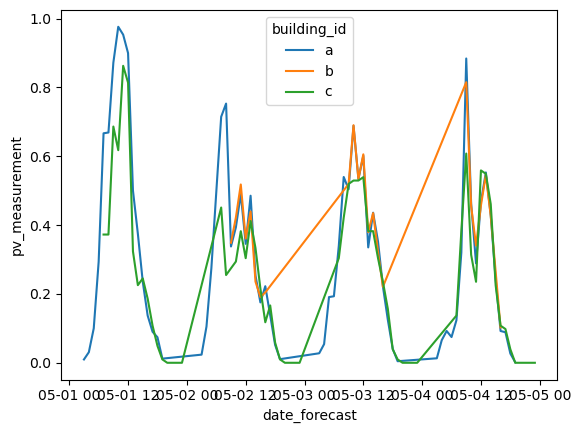

In [1785]:
Xy_temp = pd.concat([X_train, y_train.rename('pv_measurement')], axis=1)

sns.lineplot(data=Xy_temp[Xy_temp.date_forecast.between('2021-05-01','2021-05-05',)], x='date_forecast',y='pv_measurement', hue='building_id', alpha = 1)

In [1786]:
print(f"X.shape: {Xy_train.shape}")
print(f"X.shape: {Xy_test.shape}")


X.shape: (16206, 268)
X.shape: (4229, 268)


In [1787]:
test_idx = X_train['date_forecast'].between('2021/05/01', '2021/07/01') # needs to be done before dropping date_forecast

In [1788]:
# drop irrelevant columns
drop_cols = [
    'date_forecast', 
    'snow_density:kgm3',
    'date_calc', 
    'monthYear', 
    'dayMonthYear',
    'elevation:m',
    # 'isEstimated',
    # 'delta_forecast',
    ]

snow = [
    'snow_density:kgm3',
    'snow_depth:cm',
    'snow_drift:idx',
    'snow_melt_10min:mm',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
]

drop2 = ['clear_sky_energy_1h:J',
         'direct_rad_1h:J',
         'fresh_snow_24h:cm',
         'fresh_snow_1h:cm',
         'fresh_snow_12h:cm',
         'diffuse_rad_1h:J',
         'dew_point_2m:K',
         'dew_or_rime:idx',
         'precip_5min:mm',
         'fresh_snow_6h:cm',
         'prob_rime:p',
         'ceiling_height_agl:m',
         'rain_water:kgm2',
         'sfc_pressure:hPa',
         'snow_depth:cm',
         'snow_drift:idx',
         'snow_melt_10min:mm',
         'snow_water:kgm2',
         'pressure_50m:hPa',
         'wind_speed_w_1000hPa:ms',
         'pressure_100m:hPa',
         'fresh_snow_3h:cm']

minute_cols = [feature for feature in X_train.columns if feature.startswith('00_') or feature.startswith('15_') or feature.startswith('30_') or feature.startswith('45_')]



drop_cols = drop_cols + snow + minute_cols# + drop2



print(drop_cols)
# ignore if column does not exist
X_train = X_train.drop(drop_cols, axis=1, errors='ignore')
X_test = X_test.drop(drop_cols, axis=1, errors='ignore')
# ignore if column does not exist
X = X.drop(drop_cols, axis=1, errors='ignore')
X_submission = X_submission.drop(drop_cols, axis=1, errors='ignore')


['date_forecast', 'snow_density:kgm3', 'date_calc', 'monthYear', 'dayMonthYear', 'elevation:m', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'fresh_snow_1h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'fresh_snow_12h:cm', 'fresh_snow_24h:cm', '00_absolute_humidity_2m:gm3', '00_air_density_2m:kgm3', '00_ceiling_height_agl:m', '00_clear_sky_energy_1h:J', '00_clear_sky_rad:W', '00_cloud_base_agl:m', '00_dew_or_rime:idx', '00_dew_point_2m:K', '00_diffuse_rad:W', '00_diffuse_rad_1h:J', '00_direct_rad:W', '00_direct_rad_1h:J', '00_effective_cloud_cover:p', '00_fresh_snow_12h:cm', '00_fresh_snow_1h:cm', '00_fresh_snow_24h:cm', '00_fresh_snow_3h:cm', '00_fresh_snow_6h:cm', '00_is_day:idx', '00_is_in_shadow:idx', '00_msl_pressure:hPa', '00_precip_5min:mm', '00_precip_type_5min:idx', '00_pressure_100m:hPa', '00_pressure_50m:hPa', '00_prob_rime:p', '00_rain_water:kgm2', '00_relative_humidity_1000hPa:p', '00_sfc_pressure:hPa', '00_snow_density:kgm3', '00_snow_depth

In [1789]:
# imp_features = [
#     'building_id',
#     'clear_sky_rad:W',
#      'cloud_base_agl:m',
#     'diffuse_rad:W',
#     'effective_cloud_cover:p',
#     'is_in_shadow:idx',
#     'precip_5min:mm',
#     'sun_azimuth:d',
#     'sun_elevation:d',
#     't_1000hPa:K',
#      'total_cloud_cover:p',
#     'month',
#     'hour',
#     'delta_forecast',
#     'GHI',
#     'wind_angle_sin',
#     'wind_angle_cos',
#      'wind_speed_10m:ms'
# ]

# X_train = X_train[imp_features]
# X_test = X_test[imp_features]
# X_submission = X_submission[imp_features]
# X = X[imp_features]

In [1790]:
# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train.loc[:, X_train.isna().any()].columns.tolist()# + ['GHI_std']

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


categorical_features: ['building_id']
impute_features: ['mean_snow_density:kgm3', 'delta_forecast']


# Building the pipeline

In [1791]:
from sklearn.base import BaseEstimator, TransformerMixin


class StatusSaver(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # append "1," to status file
        with open('status.csv', 'a') as f:
            f.write('1\n')

        return self

    def transform(self, X):
        # Your transformation logic here
        # Return the transformed data
        return X


# create empty txt file
open('status.csv', 'w').close()

In [1792]:


# BayesSearchCV
parameters_bayes = {
    'estimator__n_estimators': Integer(30,500),
    'estimator__max_depth': Integer(6, 14),
    'estimator__learning_rate': Real(0.01, 0.3),
    # 'estimator__subsample': Real(0.5, 1.0),
    # 'estimator__colsample_bytree': Real(0.8, 1.0),
    # 'estimator__colsample_bylevel': Real(0.8, 1.0),
    # 'estimator__colsample_bynode': Real(0.8, 1.0),
    #'estimator__gamma': Real(0, 2),
    # 'estimator__reg_alpha': Real(0, 10),
    # 'estimator__reg_lambda': Real(1, 10),
    # 'estimator__min_child_weight': Integer(1, 10),
    #'estimator__max_delta_step': Integer(0, 5)
}

parameters_grid_xgb = {
     'estimator__n_estimators': np.arange(10,300,10),
    # 'estimator__max_depth': [7]#np.arange(14,3,-1),
    # 'estimator__learning_rate': np.arange(0.4, 0, -0.01),
    # 'estimator__subsample': np.arange(0.1,1,0.05),
    # 'estimator__colsample_bytree': np.arange(0.3, 1, 0.025),
    # 'estimator__colsample_bynode': np.arange(0.3, 1, 0.025),
    # 'estimator__colsample_bylevel': np.arange(0.3, 1, 0.025),
    # 'estimator__gamma': [0, 0.5, 1, 1.5, 2],
    # 'estimator__reg_alpha': np.arange(0, 3, 0.1),
    # 'estimator__reg_lambda': np.arange(0, 10, 0.25),
    # 'estimator__min_child_weight': np.arange(1, 5, 0.25),
    #  'estimator__n_estimators': np.arange(200,9,-10),
}

parameters_grid_lgbm = {
    'verbose': [1],
    #'estimator__num_leaves': [40],
   #'estimator__num_leaves': np.arange(10,251,10),
    # 'estimator__min_data_in_leaf': list(range(3,14)),
     #'estimator__max_depth': np.arange(10,3,-1),
     #'estimator__reg_alpha': np.arange(0, 10, 0.5),
    #'estimator__reg_lambda': np.arange(0, 10, 0.25),
}

parameters_grid_catb = {
    # 'estimator__iterations': [800]#np.arange(500, 2000, 50),
    #'estimator__depth': list(range(3,14)),
     'estimator__depth': np.arange(14,2,-1),
     #'estimator__reg_alpha': np.arange(0, 10, 0.5),
    #'estimator__reg_lambda': np.arange(0, 20, 0.25),
}

parameters_grid_svr = {
    'estimator__kernel': ['rbf','linear','poly'],
    #'estimator__depth': list(range(3,14)),
     #'estimator__max_depth': list(range(3,14)),
     #'estimator__reg_alpha': np.arange(0, 10, 0.5),
    #'estimator__reg_lambda': np.arange(0, 20, 0.25),
}

parameters_grid_rf = {
    # 'estimator__n_estimators':np.arange(50, 300, 50),
    # 'estimator__criterion':'gini',
    # 'estimator__max_depth':np.arange(18, 3, -2),
    # 'estimator__min_samples_split':np.arange(10, 90, 10),
    # 'estimator__min_samples_leaf':1,
    # 'estimator__min_weight_fraction_leaf':0.0,
    # 'estimator__max_features':'sqrt',
    'estimator__max_leaf_nodes':[2048],
    # 'estimator__min_impurity_decrease':0.0,
    # 'estimator__bootstrap':True,
    # 'estimator__oob_score':False,
    # 'estimator__n_jobs=None, random_state':None,
    # 'estimator__verbose=0, warm_start':False,
    # 'estimator__class_weight':None,
    # 'estimator__ccp_alpha':0.0,
    # 'estimator__max_samples':None
}



In [1793]:
def std_per_sample(y, y_pred):
    return np.std((y - y_pred), axis=0)

def TEST(y,y_pred):
    return y - y_pred

std_scorer = make_scorer(std_per_sample, greater_is_better=False)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'STD': std_scorer
}



In [1794]:
mean_cols = [col for col in X_train.columns if 'mean_' in col]
mean_cols

['mean_absolute_humidity_2m:gm3',
 'mean_air_density_2m:kgm3',
 'mean_ceiling_height_agl:m',
 'mean_clear_sky_energy_1h:J',
 'mean_clear_sky_rad:W',
 'mean_cloud_base_agl:m',
 'mean_dew_or_rime:idx',
 'mean_dew_point_2m:K',
 'mean_diffuse_rad:W',
 'mean_diffuse_rad_1h:J',
 'mean_direct_rad:W',
 'mean_direct_rad_1h:J',
 'mean_effective_cloud_cover:p',
 'mean_fresh_snow_12h:cm',
 'mean_fresh_snow_1h:cm',
 'mean_fresh_snow_24h:cm',
 'mean_fresh_snow_3h:cm',
 'mean_fresh_snow_6h:cm',
 'mean_is_day:idx',
 'mean_is_in_shadow:idx',
 'mean_msl_pressure:hPa',
 'mean_precip_5min:mm',
 'mean_precip_type_5min:idx',
 'mean_pressure_100m:hPa',
 'mean_pressure_50m:hPa',
 'mean_prob_rime:p',
 'mean_rain_water:kgm2',
 'mean_relative_humidity_1000hPa:p',
 'mean_sfc_pressure:hPa',
 'mean_snow_density:kgm3',
 'mean_snow_depth:cm',
 'mean_snow_drift:idx',
 'mean_snow_melt_10min:mm',
 'mean_snow_water:kgm2',
 'mean_sun_azimuth:d',
 'mean_sun_elevation:d',
 'mean_super_cooled_liquid_water:kgm2',
 'mean_t_100

In [1795]:
X_train

,building_id,isEstimated,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,month,hour,delta_forecast,mean_GHI,mean_wind_angle,mean_wind_angle_sin,mean_wind_angle_cos,hour_sin,hour_cos,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad
0,a,0,8.425,1.21800,1283.425049,2.086500e+02,0.750000,1283.425049,0.0,281.674988,0.300000,526.775024,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1004.025024,0.0,0.0,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,NaN,0.0,0.0,0.0,0.55,28.630251,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,6,1,NaN,0.300000,-1.246164,-0.947768,0.318960,0.258819,9.659258e-01,86.025002,201.309372,-0.246750
1,a,0,8.950,1.21800,1003.500000,3.246815e+04,23.100000,1003.500000,0.0,282.500000,11.975000,22068.949219,0.150000,282.975006,84.875000,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.25,41.997501,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,6,2,NaN,12.125000,-1.195805,-0.930511,0.366265,0.500000,8.660254e-01,3473.206299,203.808762,36.538719
2,a,0,9.250,1.21650,809.375000,1.794991e+05,84.375000,809.375000,0.0,283.049988,45.125000,102788.046875,6.300000,11627.549805,65.025002,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1002.349976,0.0,0.0,989.750000,995.700012,0.0,0.000,82.849998,1001.674988,NaN,0.0,0.0,0.0,0.10,55.041748,8.071000,0.0,286.475006,94.800003,29848.199219,2.300,-2.200,0.800,0.0,6,3,NaN,51.424999,-1.222025,-0.939793,0.341743,0.707107,7.071068e-01,14731.976562,190.554993,364.203888
3,a,0,9.525,1.21300,757.775024,4.781178e+05,186.649994,757.775024,0.0,283.524994,89.525002,242438.000000,43.724998,90073.375000,77.550003,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1001.825012,0.0,0.0,989.250000,995.200012,0.0,0.000,82.275002,1001.174988,NaN,0.0,0.0,0.0,0.00,67.898003,13.956500,0.0,286.825012,95.099998,35980.148438,2.325,-2.200,0.750,0.0,6,4,NaN,133.250000,-1.242243,-0.946510,0.322674,0.866025,5.000000e-01,38219.433594,191.289383,1249.455688
4,a,0,9.700,1.20750,705.650024,8.926679e+05,311.525024,705.650024,0.0,283.799988,139.000000,411381.906250,53.099998,174254.546875,85.050003,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1001.200012,0.0,0.0,988.700012,994.599976,0.0,0.000,78.699997,1000.500000,NaN,0.0,0.0,0.0,0.00,80.821251,20.406250,0.0,287.325012,97.150002,37874.523438,2.225,-2.000,0.950,0.0,6,5,NaN,192.100006,-1.127348,-0.903277,0.429057,0.965926,2.588190e-01,55195.136719,175.107483,2836.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16201,c,1,4.500,1.26225,4533.200195,1.716165e+06,416.549988,716.650024,0.0,272.325012,162.899994,630730.750000,147.225006,611257.625000,82.675003,0.0,0.0,0.3,0.0,0.0,1.00,0.0,1014.375000,0.0,0.0,998.599976,1004.775024,0.0,0.000,64.599998,1010.974976,NaN,0.0,0.0,0.0,0.00,250.933502,25.441000,0.0,276.649994,82.675003,25419.875000,6.025,6.025,0.225,0.0

In [1796]:
# set column transformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

xgb = xgboost.XGBRegressor(
    random_state=42,
    learning_rate=0.1,
    max_depth=7,
    # reg_alpha=2,
    # reg_lambda=5,
    n_estimators=50,
    colsample_bytree=0.5,
    # subsample=0.5,
    # min_child_weight=2,

)

lgbm = LGBMRegressor(
    num_leaves=40,
    min_data_in_leaf=7,
    max_depth=5,
    random_state=42,
    reg_alpha = 2,
    #reg_lambda = 7,
)

rdf = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    # min_samples_split=50,
    max_leaf_nodes = 100
)

svr = SVR(
)

catboost = CatBoostRegressor(
    cat_features = ['building_id'],
    iterations=800,
    depth=16,
)

xgb_onehot = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', xgb)
])

lgbm_onehot = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', lgbm)
])

vote = VotingRegressor(estimators=[('xgb',xgb_onehot),('lgbm',lgbm_onehot),('cat',catboost)]) 

# build the pipeline
pipeline = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    #('standardizer', StandardScaler()),
    ('statusSaver', StatusSaver()),
    ('estimator', xgb)
])



# create bayesian search estimator
m1_BayesCV = BayesSearchCV(
    pipeline, parameters_bayes, scoring='neg_mean_absolute_error', cv=6, error_score='raise',n_points=6, n_jobs=-1, verbose=2, n_iter=1080, random_state=42)


m1_GridCV = GridSearchCV(
    pipeline, parameters_grid_xgb, scoring=scoring, cv=ps, error_score='raise', n_jobs=-1, verbose=2, refit='MAE') # 'MAE'

# switch between BayesCV and GridCV
m1_CV = m1_GridCV

# fit the estimator on the data
m1_CV.fit(X_train, y_train)

# vote.fit(X_train, y_train)

# get best model 
m1 = m1_CV.best_estimator_
# m1 = vote


Fitting 1 folds for each of 29 candidates, totalling 29 fits
[CV] END .........................estimator__n_estimators=10; total time=   0.3s
[CV] END .........................estimator__n_estimators=20; total time=   0.4s
[CV] END .........................estimator__n_estimators=30; total time=   0.6s
[CV] END .........................estimator__n_estimators=60; total time=   0.6s
[CV] END .........................estimator__n_estimators=50; total time=   0.7s
[CV] END .........................estimator__n_estimators=40; total time=   0.7s
[CV] END .........................estimator__n_estimators=70; total time=   0.8s
[CV] END .........................estimator__n_estimators=80; total time=   0.8s
[CV] END .........................estimator__n_estimators=90; total time=   0.8s
[CV] END ........................estimator__n_estimators=110; total time=   1.0s
[CV] END ........................estimator__n_estimators=100; total time=   1.4s
[CV] END ........................estimator__n_es

In [1798]:
# print the scores
# print('Best score:', m1_CV.best_score_)
print('Best parameters:', m1_CV.best_params_)

Best parameters: {'estimator__n_estimators': 50}


In [1799]:
m1_CV.param_grid

{'estimator__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
        140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
        270, 280, 290])}

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option

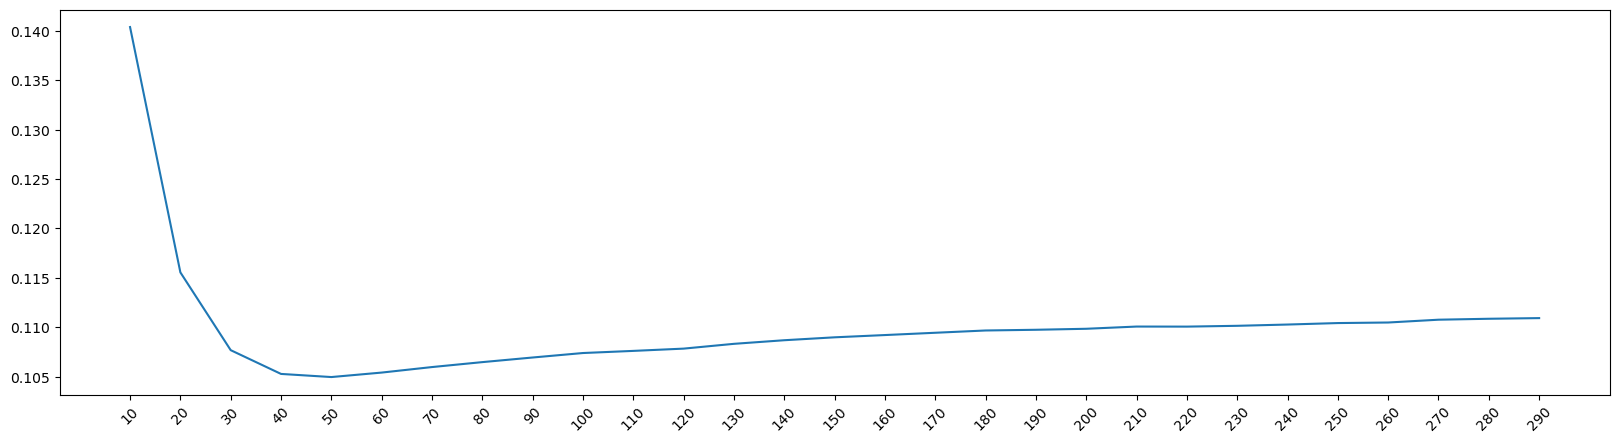

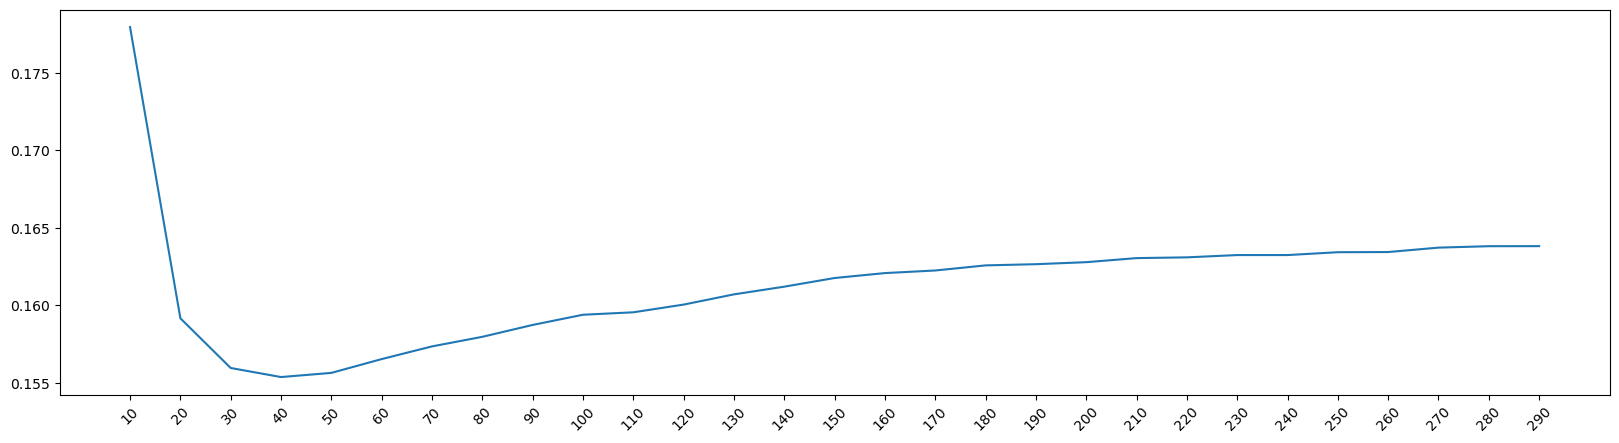

In [1800]:

for key, values in m1_CV.param_grid.items():
    pass

plt.figure(figsize=(20, 5))


sns.lineplot(y=m1_CV.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);


plt.figure(figsize=(20, 5))
sns.lineplot(y=m1_CV.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);


<Axes: xlabel='feature'>

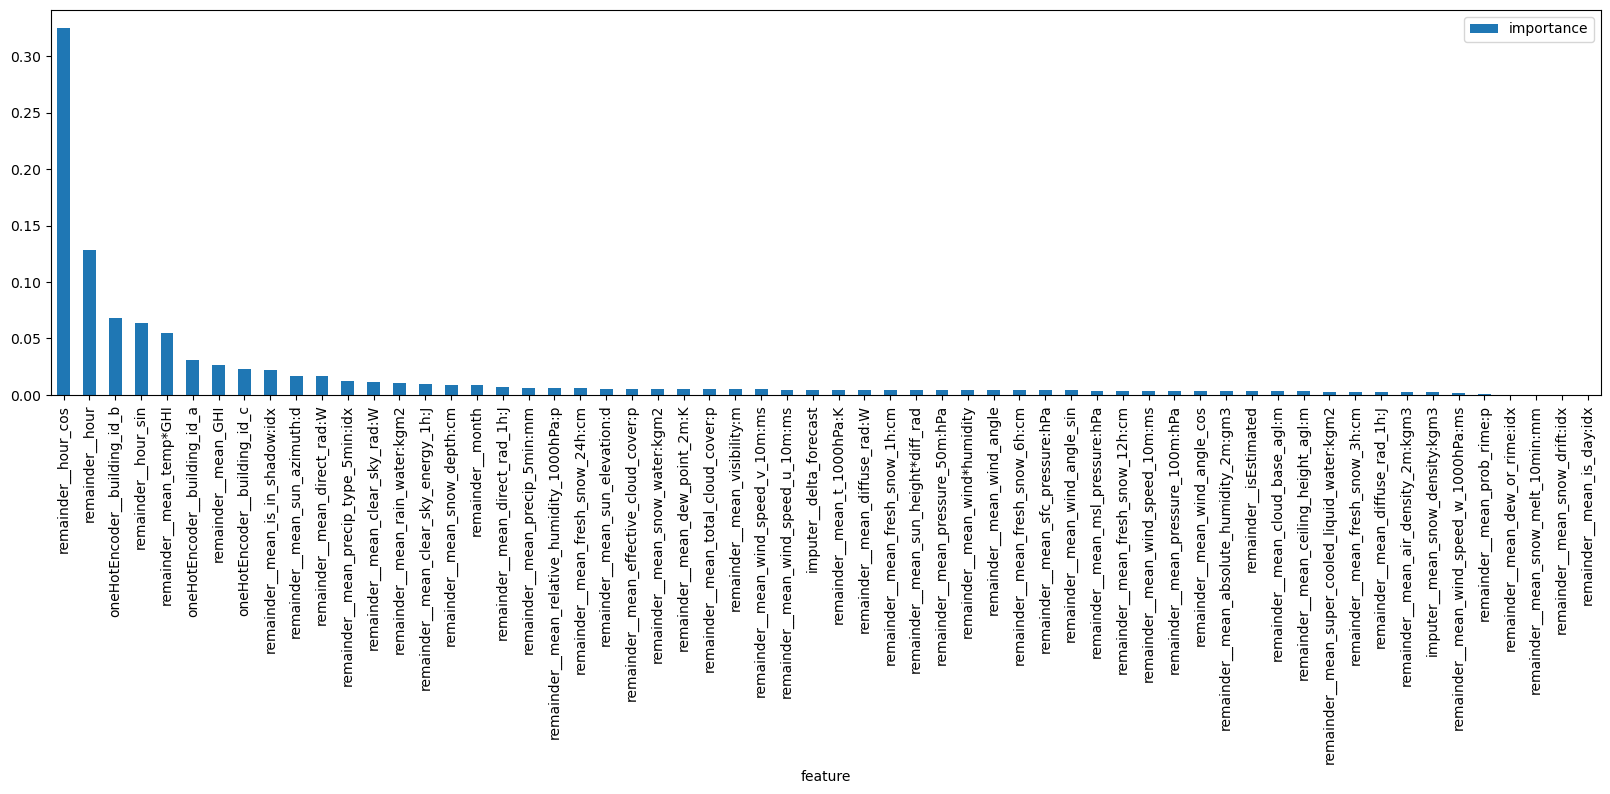

In [1801]:
#f_names = m1[:-1].get_feature_names_in()
f_names = X_train.columns.tolist()
f_names = m1.steps[-3][1].get_feature_names_out()
f_importances = m1.steps[-1][1].feature_importances_

f_importances_df = pd.DataFrame({'feature': f_names, 'importance': f_importances})

f_importances_df = f_importances_df.sort_values(by='importance', ascending=False)[0:100]

f_importances_df.plot.bar(x='feature', y='importance', figsize=(20, 5))

In [1802]:
X_train

,building_id,isEstimated,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,month,hour,delta_forecast,mean_GHI,mean_wind_angle,mean_wind_angle_sin,mean_wind_angle_cos,hour_sin,hour_cos,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad
0,a,0,8.425,1.21800,1283.425049,2.086500e+02,0.750000,1283.425049,0.0,281.674988,0.300000,526.775024,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1004.025024,0.0,0.0,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,NaN,0.0,0.0,0.0,0.55,28.630251,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,6,1,NaN,0.300000,-1.246164,-0.947768,0.318960,0.258819,9.659258e-01,86.025002,201.309372,-0.246750
1,a,0,8.950,1.21800,1003.500000,3.246815e+04,23.100000,1003.500000,0.0,282.500000,11.975000,22068.949219,0.150000,282.975006,84.875000,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.25,41.997501,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,6,2,NaN,12.125000,-1.195805,-0.930511,0.366265,0.500000,8.660254e-01,3473.206299,203.808762,36.538719
2,a,0,9.250,1.21650,809.375000,1.794991e+05,84.375000,809.375000,0.0,283.049988,45.125000,102788.046875,6.300000,11627.549805,65.025002,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1002.349976,0.0,0.0,989.750000,995.700012,0.0,0.000,82.849998,1001.674988,NaN,0.0,0.0,0.0,0.10,55.041748,8.071000,0.0,286.475006,94.800003,29848.199219,2.300,-2.200,0.800,0.0,6,3,NaN,51.424999,-1.222025,-0.939793,0.341743,0.707107,7.071068e-01,14731.976562,190.554993,364.203888
3,a,0,9.525,1.21300,757.775024,4.781178e+05,186.649994,757.775024,0.0,283.524994,89.525002,242438.000000,43.724998,90073.375000,77.550003,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1001.825012,0.0,0.0,989.250000,995.200012,0.0,0.000,82.275002,1001.174988,NaN,0.0,0.0,0.0,0.00,67.898003,13.956500,0.0,286.825012,95.099998,35980.148438,2.325,-2.200,0.750,0.0,6,4,NaN,133.250000,-1.242243,-0.946510,0.322674,0.866025,5.000000e-01,38219.433594,191.289383,1249.455688
4,a,0,9.700,1.20750,705.650024,8.926679e+05,311.525024,705.650024,0.0,283.799988,139.000000,411381.906250,53.099998,174254.546875,85.050003,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1001.200012,0.0,0.0,988.700012,994.599976,0.0,0.000,78.699997,1000.500000,NaN,0.0,0.0,0.0,0.00,80.821251,20.406250,0.0,287.325012,97.150002,37874.523438,2.225,-2.000,0.950,0.0,6,5,NaN,192.100006,-1.127348,-0.903277,0.429057,0.965926,2.588190e-01,55195.136719,175.107483,2836.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16201,c,1,4.500,1.26225,4533.200195,1.716165e+06,416.549988,716.650024,0.0,272.325012,162.899994,630730.750000,147.225006,611257.625000,82.675003,0.0,0.0,0.3,0.0,0.0,1.00,0.0,1014.375000,0.0,0.0,998.599976,1004.775024,0.0,0.000,64.599998,1010.974976,NaN,0.0,0.0,0.0,0.00,250.933502,25.441000,0.0,276.649994,82.675003,25419.875000,6.025,6.025,0.225,0.0

In [1803]:
if type(m1_CV) == BayesSearchCV:
    _ = plot_objective(m1_CV.optimizer_results_[0])
    plt.show()

# Test model on test data

In [1804]:
# predict on estimated data
m1.fit(X_train[~test_idx].reset_index(drop=True), y_train[~test_idx].reset_index(drop=True))


m1_pred = pd.Series(m1.predict(X_test))
#m1_pred = pd.Series(full_scaler.inverse_transform(m1_pred.values.reshape(-1, 1)).flatten())
#m1_pred = y_scaler.inverse_transform(m1_pred, X_e['building_id'])
# m1_pred = y_scaler_clear_sky.inverse_transform(m1_pred, X_test['clear_sky_rad:W'])
# m1_pred = y_scaler_clear_sky_y.inverse_transform(m1_pred, X_test['clear_sky_rad:W'])
m1_pred = y_scaler_MaxAbs.inverse_transform(m1_pred, X_test['building_id'])

m1_pred = m1_pred.clip(lower=0) # zero m1 pred
Xy_test['m1_pred'] = m1_pred

# calculate abs diff
Xy_test['abs_diff'] = np.abs(Xy_test['pv_measurement'] - Xy_test['m1_pred'])
Xy_test['diff'] = (Xy_test['pv_measurement'] - Xy_test['m1_pred'])

# calculate mae
mae = Xy_test['abs_diff'].mean()
print('MAE:', mae)


MAE: 196.66253138053455


In [1805]:
Xy_test['m1_pred'] = m1_pred #* 1.04

# calculate abs diff
Xy_test['abs_diff'] = np.abs(Xy_test['pv_measurement'] - Xy_test['m1_pred'])
Xy_test['diff'] = (Xy_test['pv_measurement'] - Xy_test['m1_pred'])

Xy_test['m1_pred_transformed'] = Xy_test.apply(lambda row: 0 if row['45_sun_elevation:d'] < -1 else row['m1_pred'], axis=1)

# calculate abs diff
Xy_test['abs_diff_transformed'] = np.abs(Xy_test['pv_measurement'] - Xy_test['m1_pred_transformed'])
Xy_test['diff_transformed'] = (Xy_test['pv_measurement'] - Xy_test['m1_pred_transformed'])

# calculate mae
mae = Xy_test['abs_diff'].mean()
print('MAE:', mae)

# calculate mae
mae = Xy_test['abs_diff_transformed'].mean()
print('MAE tranformed:', mae)

MAE: 196.66253138053455
MAE tranformed: 191.7166904581602


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

KeyError: 'GHI'

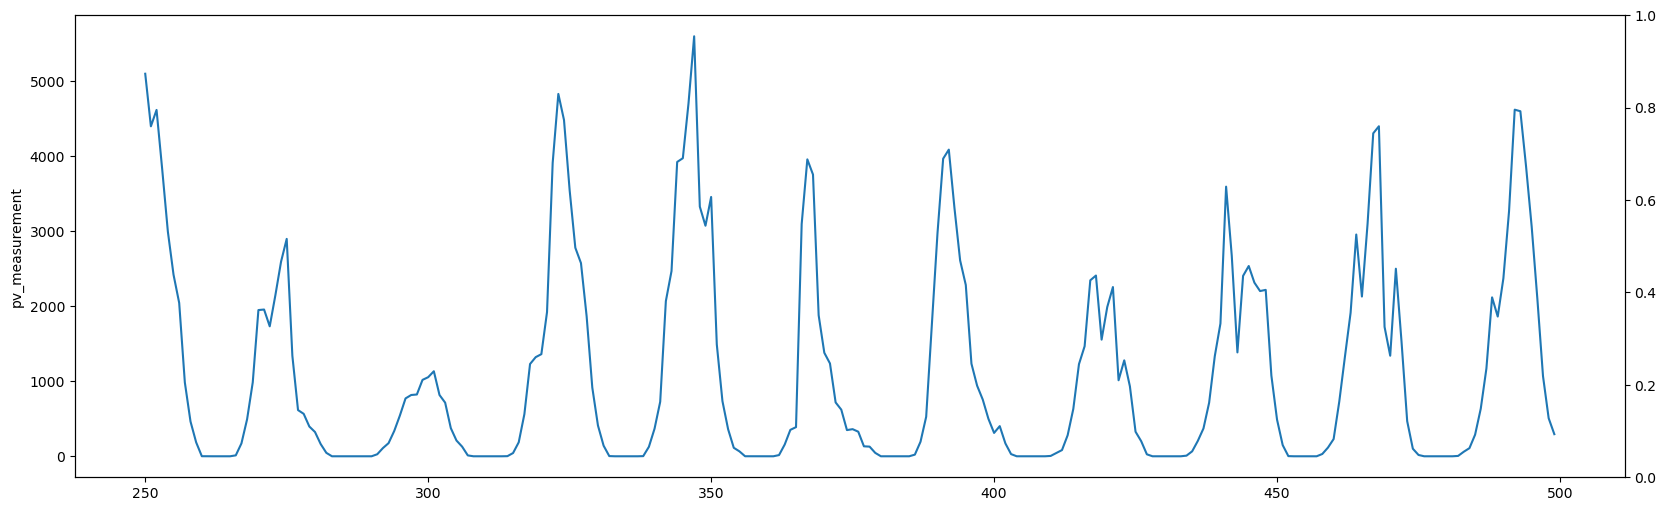

In [1806]:
plt.figure(figsize=(20, 6))

index_from = 250
index_to = 500

ax_1 = sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='pv_measurement')
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='m1_pred',ax=ax_1)
ax_2 = ax_1.twinx()
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='effective_cloud_cover:p', color='red', ax=ax_2)
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='cloud_cover_lag-1', color='black', ax=ax_2)
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='GHI', color='red', ax=ax_2)
Xy_test['cloud*ghi'] = Xy_test['GHI'] * Xy_test['effective_cloud_cover:p']
sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='effective_cloud_cover_5h_mean', color='black', ax=ax_2)
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='diffuse_rad:W', color='green', ax=ax_2)


plt.show()
plt.figure(figsize=(20, 6))
sns.lineplot(data=Xy_test[:500], x=Xy_test.index[:500], y='pv_measurement',color='black')
sns.lineplot(data=Xy_test[:500], x=Xy_test.index[:500], y='m1_pred_transformed',color='red')
plt.show()


<Axes: >

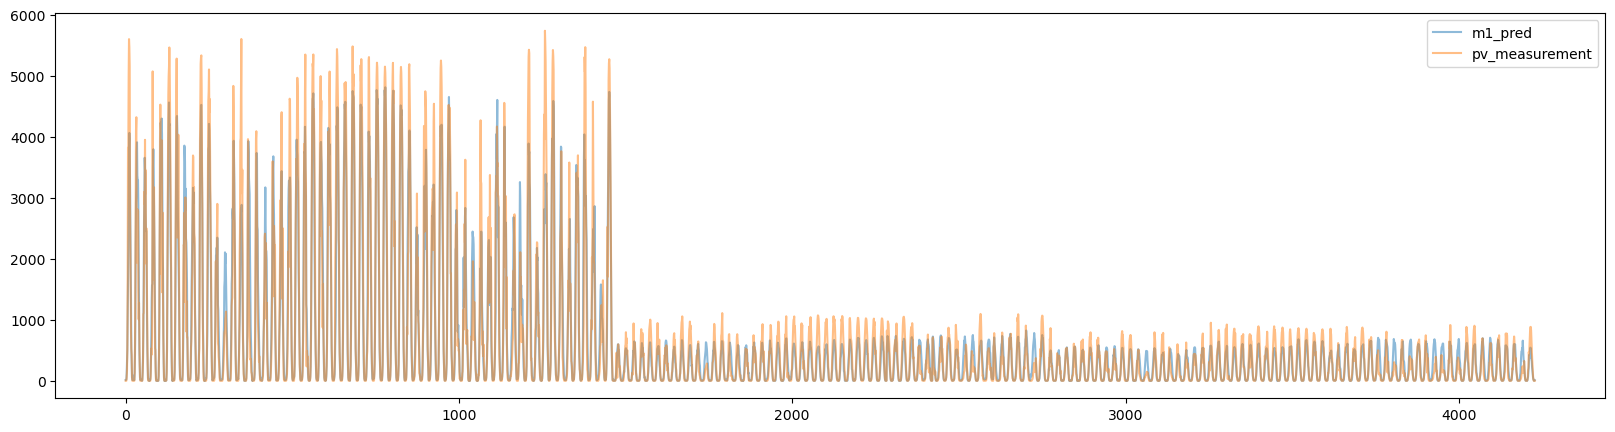

In [ ]:
Xy_test[['m1_pred','pv_measurement']].plot(figsize=(20,5), alpha=0.5)

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

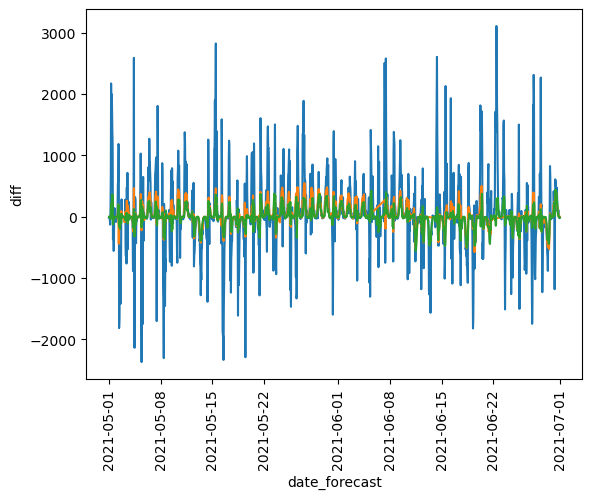

In [ ]:
sns.lineplot(data=Xy_test, x='date_forecast', y='diff', hue='building_id', legend=False)
plt.xticks(rotation=90);


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


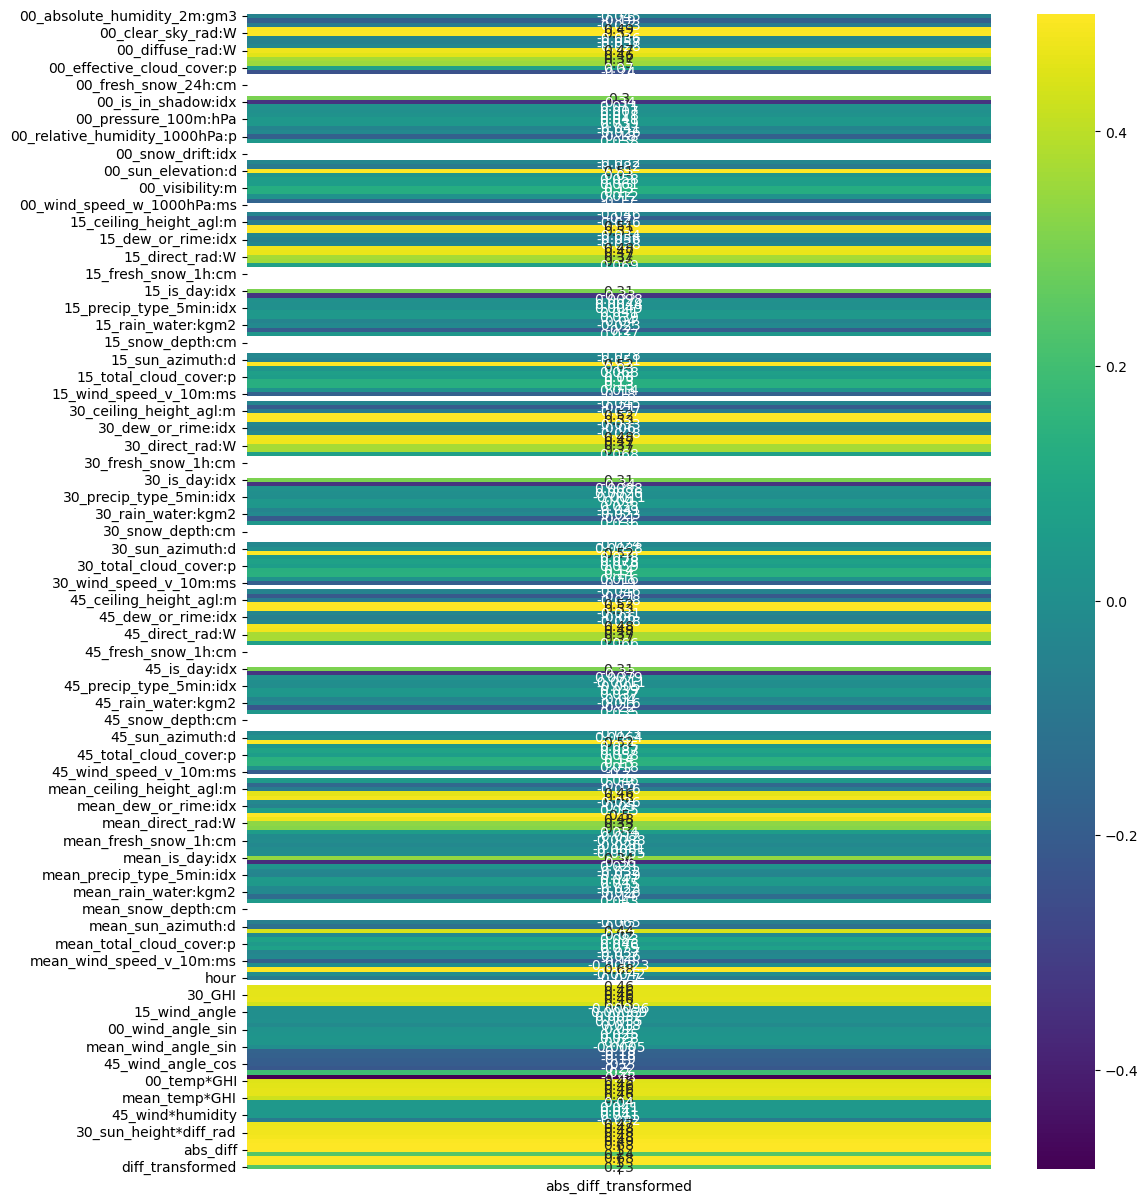

In [ ]:
corr_y = Xy_test.corr(numeric_only=True)['abs_diff_transformed'].to_frame()
f, ax = plt.subplots(figsize=(12, 15))
sns.heatmap(corr_y, vmax=.5, cmap='viridis', annot=True);

In [ ]:
X_submission = X_submission.ffill().bfill()

In [ ]:
# Creating the submission file
m1.fit(X, y)

# prepare dataframes
y_test_pred = pd.Series(m1.predict(X_submission))
# y_test_pred = pd.Series(full_scaler.inverse_transform(
#     y_test_pred.values.reshape(-1, 1)).flatten())
#y_test_pred = y_scaler.inverse_transform(y_test_pred, X_t['building_id']).copy()
# y_test_pred = y_scaler_clear_sky_y.inverse_transform(y_test_pred, X_submission['GHI']).copy()
y_test_pred = y_scaler_MaxAbs_y.inverse_transform(y_test_pred, X_submission['building_id']).copy()

# remove negative predictions
y_test_pred = y_test_pred.clip(lower=0)

Xy_pred_submission = pd.concat([X_submission, y_test_pred.rename('prediction')], axis=1)
Xy_pred_submission['prediction'] = Xy_pred_submission.apply(lambda row: 0 if row['sun_elevation:d'] < 1 else row['prediction'], axis=1)

# rename columns etc.
y_test_pred = y_test_pred.reset_index().rename(
    columns={0: 'prediction', 'index': 'id'})

# save submission file
Xy_pred_submission['prediction'].to_csv(
    'with_isEstimated.csv', index=True, header=True)

KeyError: 'sun_elevation:d'

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

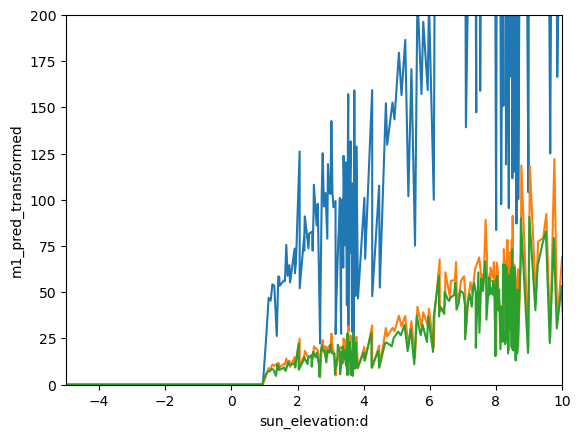

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

<Axes: xlabel='sun_elevation:d', ylabel='pv_measurement'>

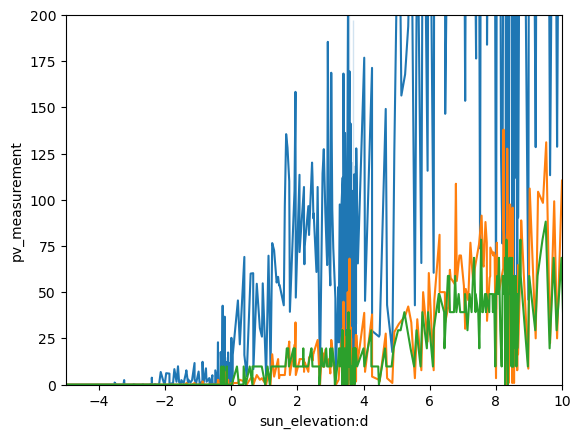

In [ ]:
ax = plt.gca()
plt.ylim(0, 200)
plt.xlim(-5,10)
sns.lineplot(data=Xy_test, x='sun_elevation:d', y='m1_pred_transformed', hue='building_id', legend=False, ax=ax)

plt.show()

ax = plt.gca()
plt.ylim(0, 200)
plt.xlim(-5,10)
# plt.xlim(-20,0)
sns.lineplot(data=Xy_test, x='sun_elevation:d', y='pv_measurement', hue='building_id', legend=False, ax=ax)

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

<Axes: ylabel='pv_measurement'>

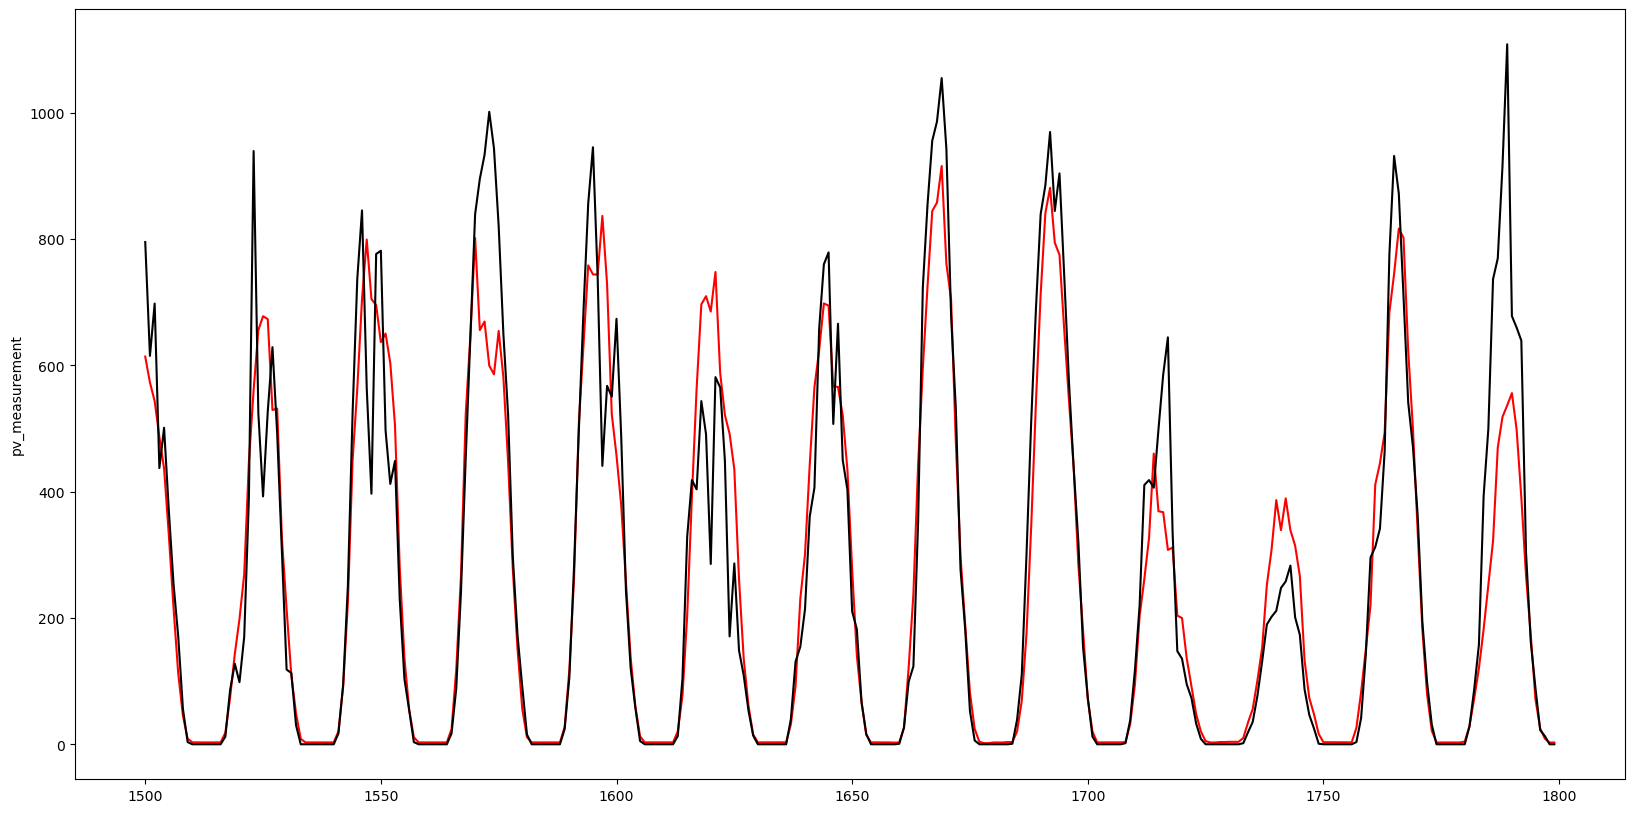

In [ ]:
idx_start = 1500
idx_end = idx_start + 300

m1_pred
plt.figure(figsize=(20,10))
# sns.lineplot(cat[idx_start:index_end],color='blue')
sns.lineplot(m1_pred[idx_start:idx_end],color='red')
sns.lineplot(Xy_test['pv_measurement'][idx_start:idx_end],color='black')

#